In [1]:
import datetime
import random
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display
from matplotlib.pyplot import figure

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings("ignore")

В городе на каждой дороге поставили камеры для измерения ее загруженности каждые 20 минут. Собирается статистика в формате: 
    
    x - координата средней точки проезжей части с востока на запад, 
    y - координата средней точки дороги с севера на юг, 
    direction - направление движения проезжей части, 
    time - время измерения, 
    overload - загруженность дороги (от 0 до 100). 

Необходимо спрогнозировать загруженность всех дорог (сочетание x, y, direction) на следующую неделю с интервалом 20 минут.

В этом ноутбуку описан эконометрический подход.

In [2]:
df = pd.read_excel('train_dataset.xlsx')
source = df.copy()

print(df.sample(1))

        x  y                time direction  overload
212410  2  2 2023-05-30 13:40:00        SB        71


In [3]:
# пропущенных значений нет 
df.shape, df.isnull().sum().sum()

((783380, 5), 0)

In [4]:
start_train = min(df['time']).strftime('%Y-%m-%d')
end_train = max(df['time']).strftime('%Y-%m-%d')

start_train, end_train

('2023-04-01', '2023-09-30')

In [5]:
# пропущенные даты
print(pd.date_range(start=start_train, end=end_train).difference(df.time))

DatetimeIndex(['2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
               '2023-05-19', '2023-05-20', '2023-05-21', '2023-05-22',
               '2023-05-23', '2023-05-24', '2023-05-25', '2023-05-26',
               '2023-05-27', '2023-05-28'],
              dtype='datetime64[ns]', freq='D')


In [6]:
# добавляем пропущенные даты с overload = 0
key_cols = ['x', 'y', 'direction']
unique_rows = df[key_cols].drop_duplicates()
unique_rows['key'] = 0

dates_data = pd.DataFrame({'time': pd.date_range(start=start_train, end=end_train, freq="20min")})
dates_data['key'] = 0
all_rows_date = unique_rows.merge(dates_data, how='outer', on=['key']).drop(['key'], axis=1)
df = all_rows_date.merge(df, how='left', on=key_cols + ['time'])
df['overload'] = df['overload'].fillna(0).astype(int)

dt = datetime.datetime(2023,5,15)
df[df['time'] == dt].head(3)

,x,y,direction,time,overload
3168,0,0,EB,2023-05-15,0
16273,0,0,NB,2023-05-15,0
29378,0,0,SB,2023-05-15,0


In [7]:
# в одном дне для каждого уникального x, y, direction 72 точки наблюдений
dt_st = datetime.datetime(2023, 7, 11)
dt_en = datetime.datetime(2023, 7, 12)
day_sample = df[(df['time'] >= dt_st) & (df['time'] < dt_en)]
day_sample[['x', 'y', 'direction']].value_counts()[:2]

x  y  direction
0  0  EB           72
1  3  EB           72
Name: count, dtype: int64

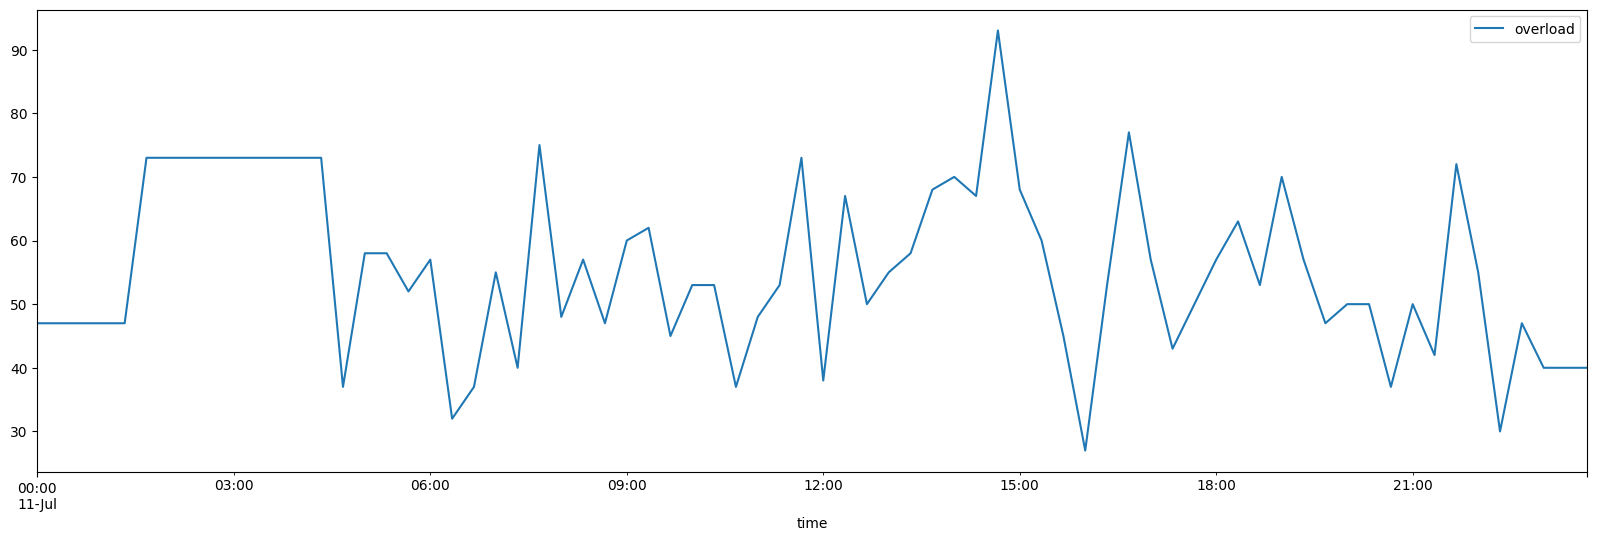

In [12]:
x_0_y_0_EB_day = day_sample[(day_sample['x'] == 0) & (day_sample['y'] == 0) & (day_sample['direction'] == 'EB')].sort_values('time')
x_0_y_0_EB_day.plot(x='time', y='overload', figsize=(20, 6));

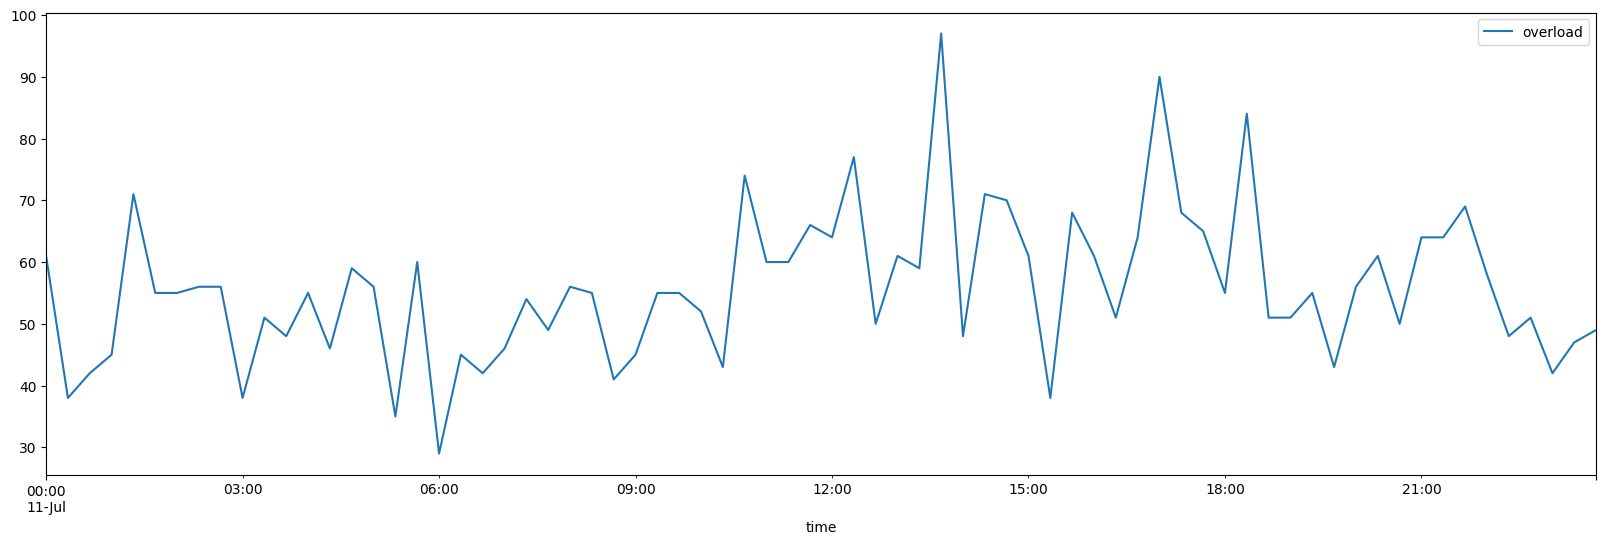

In [17]:
x_1_y_0_NB_day = day_sample[(day_sample['x'] == 1) & (day_sample['y'] == 0) & (day_sample['direction'] == 'NB')].sort_values('time')
x_1_y_0_NB_day.plot(x='time', y='overload', figsize=(20, 6));

In [18]:
# в неделях выделяются повторяющиеся паттерны дней
dt_st = datetime.datetime(2023, 7, 10)
dt_en = datetime.datetime(2023, 7, 17)
sample_week = df[(df['time'] >= dt_st) & (df['time'] < dt_en)]

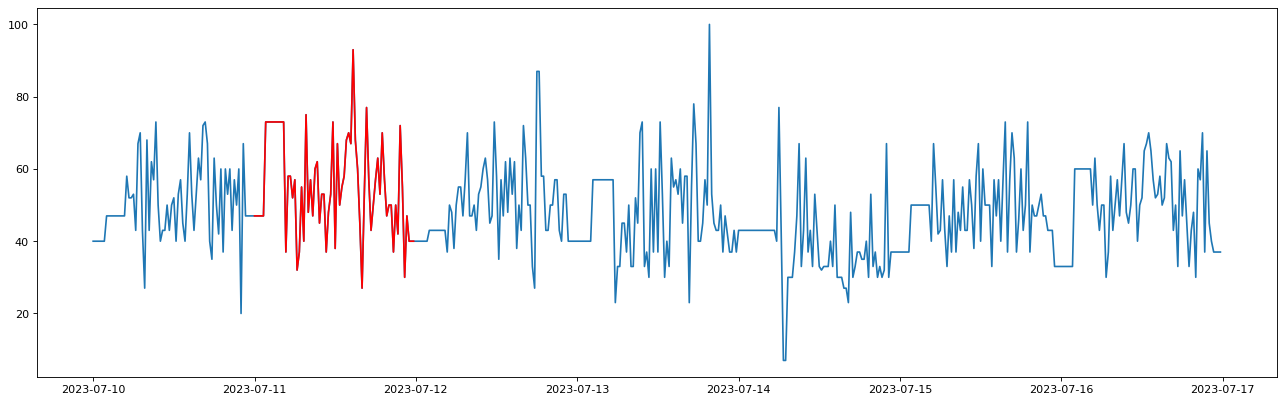

In [19]:
x_0_y_0_EB_week = sample_week[(sample_week['x'] == 0) & (sample_week['y'] == 0) & (sample_week['direction'] == 'EB')].sort_values('time')

figure(figsize=(20, 6), dpi=80)
plt.plot(x_0_y_0_EB_week['time'], x_0_y_0_EB_week['overload']);
plt.plot(x_0_y_0_EB_day['time'], x_0_y_0_EB_day['overload'], c='r');

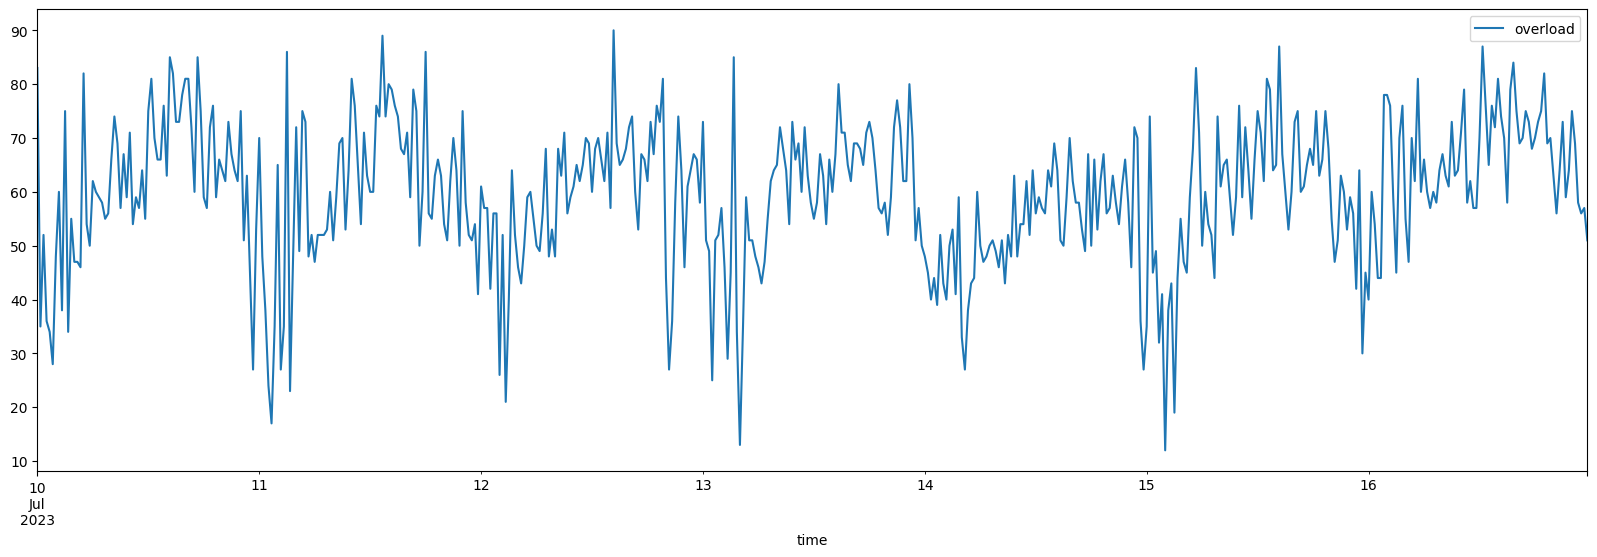

In [20]:
x_2_y_0_EB_week = sample_week[(sample_week['x'] == 2) & (sample_week['y'] == 0) & (sample_week['direction'] == 'EB')].sort_values('time')
x_2_y_0_EB_week.plot(x='time', y='overload', figsize=(20, 6));

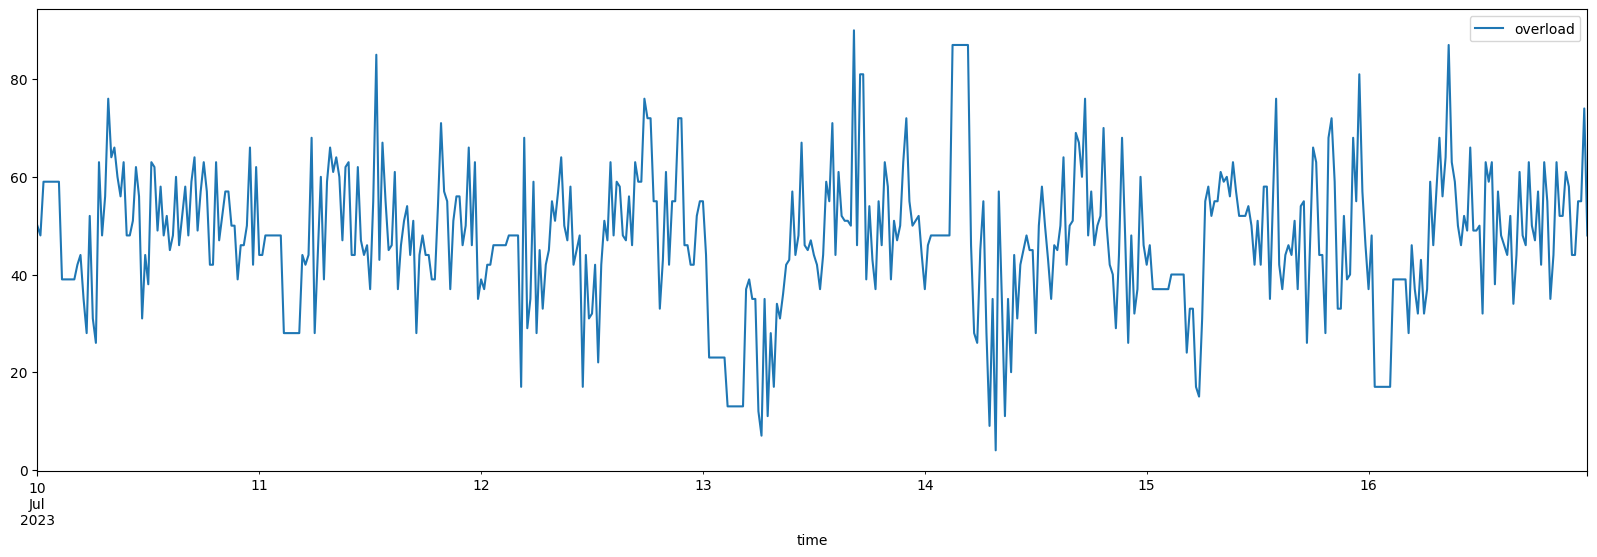

In [21]:
x_2_y_3_EB_week = sample_week[(sample_week['x'] == 2) & (sample_week['y'] == 3) & (sample_week['direction'] == 'EB')].sort_values('time')
x_2_y_3_EB_week.plot(x='time', y='overload', figsize=(20, 6));

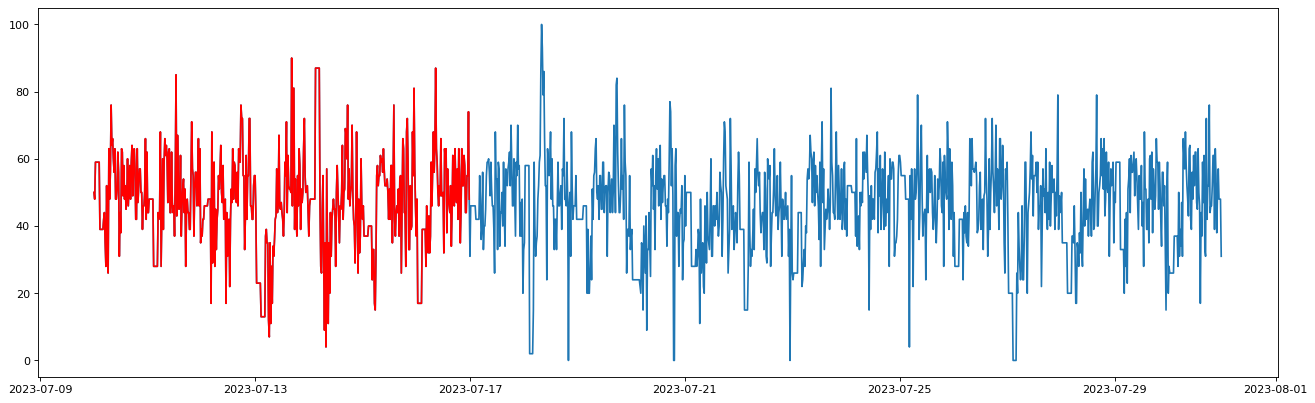

In [24]:
# посмотрим насколько похожи последние 3 недели
dt_st = datetime.datetime(2023, 7, 10)
dt_en = datetime.datetime(2023, 7, 31)
sample_3_week = df[(df['time'] >= dt_st) & (df['time'] < dt_en)]

x_2_y_3_EB_3_week = sample_3_week[(sample_3_week['x'] == 2) & (sample_3_week['y'] == 3) & (sample_3_week['direction'] == 'EB')].sort_values('time')

figure(figsize=(20, 6), dpi=80)
plt.plot(x_2_y_3_EB_3_week['time'], x_2_y_3_EB_3_week['overload']);
plt.plot(x_2_y_3_EB_week['time'], x_2_y_3_EB_week['overload'], c='r');

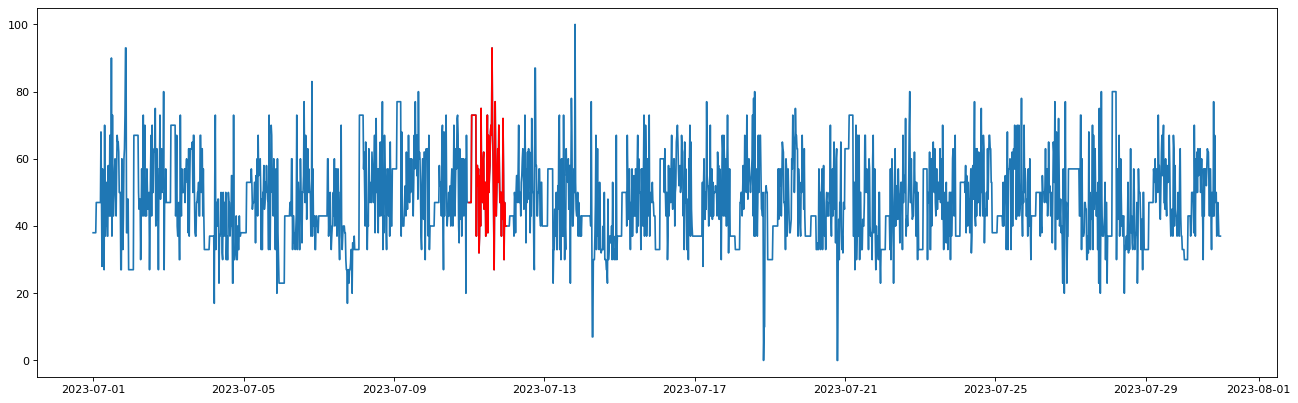

In [26]:
# посмотрим на 1 месяц
dt_st = datetime.datetime(2023, 7, 1)
dt_en = datetime.datetime(2023, 7, 31)
sample_mnth = df[(df['time'] >= dt_st) & (df['time'] < dt_en)]

x_0_y_0_EB_mnth = sample_mnth[(sample_mnth['x'] == 0) & (sample_mnth['y'] == 0) & (sample_mnth['direction'] == 'EB')].sort_values('time')

figure(figsize=(20, 6), dpi=80)
plt.plot(x_0_y_0_EB_mnth['time'], x_0_y_0_EB_mnth['overload']);
plt.plot(x_0_y_0_EB_day['time'], x_0_y_0_EB_day['overload'], c='r');

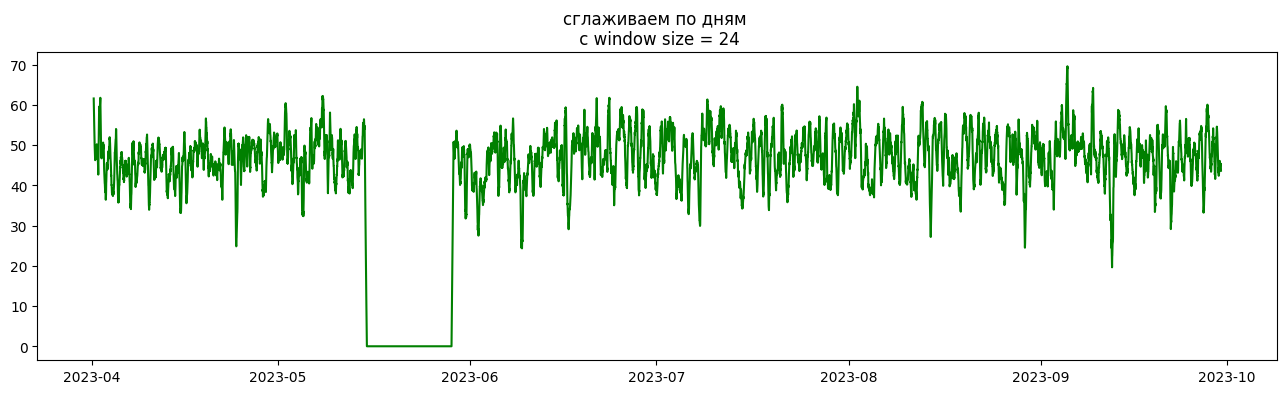

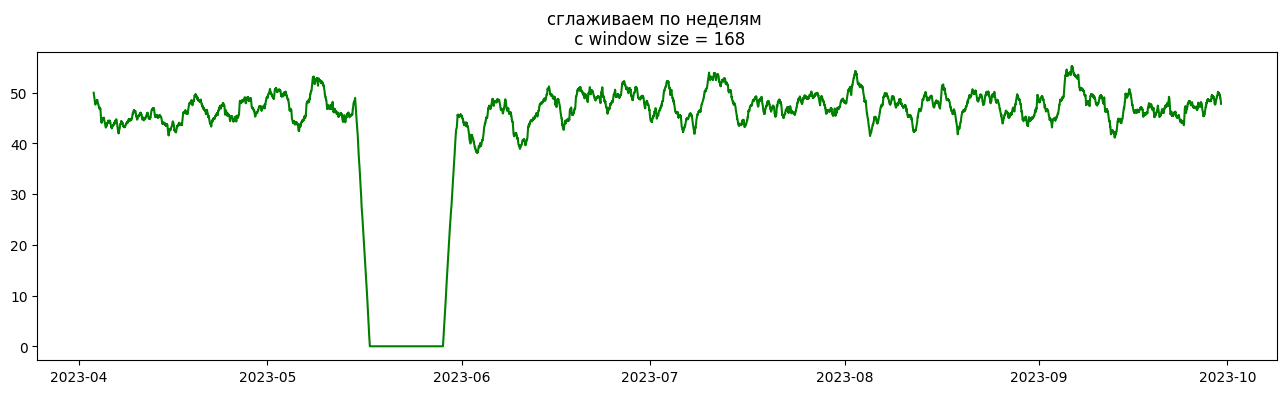

In [13]:
# посмотрим на весь период
sample_all = df

x_1_y_1_SB_all = sample_all[(sample_all['x'] == 1) & (sample_all['y'] == 1) & (sample_all['direction'] == 'SB')].sort_values('time')
x_0_y_0_EB_all = sample_all[(sample_all['x'] == 0) & (sample_all['y'] == 0) & (sample_all['direction'] == 'EB')].sort_values('time')

def moving_average(series, n):
    return np.average(series[-n:])

def plotMovingAverage(dates, series, n1=24, n2=24*7):

    rolling_mean1 = series.rolling(window=n1).mean()
    N1 = len(rolling_mean1)

    plt.figure(figsize=(16,4))
    plt.title("сглаживаем по дням \n c window size = {}".format(n1))
    plt.plot(dates[:N1], rolling_mean1, "g", label="Rolling mean trend")

    rolling_mean2 = series.rolling(window=n2).mean()
    N2 = len(rolling_mean2)

    plt.figure(figsize=(16,4))
    plt.title("сглаживаем по неделям \n c window size = {}".format(n2))
    plt.plot(dates[:N1],rolling_mean2, "g", label="Rolling mean trend")
   

plotMovingAverage(dates=x_0_y_0_EB_all['time'], series=x_0_y_0_EB_all['overload'])

в ряду чётко отслеживаются только повторяющиеся паттерны дней. потенциально можно предсказывать несколько дней в будущем по предыдущим дням

In [28]:
unique_keys = df[['x', 'y', 'direction']].drop_duplicates()
print(f'Всего {len(unique_keys)} точек наблюдения')

Всего 65 точек наблюдения


потенциально нужно сделать прогноз для 65 рядов, для каждой SARIMA модели подобрать параметры по графикам автокорреляции. хотя это можно сделать авто подбором, кажется что это очень долго. можно попытаться сгрупировать ряды на похожие и делать для низ одниаковые предсказания, но это ещё одна задача 

In [29]:
# проверка всех рядов на стационарность с помощью критерия Дики-Фуллера
p_fuller = []
for row in unique_keys.itertuples():
    df_sample = df[(df['x'] == row.x) & (df['y'] == row.y) & (df['direction'] == row.direction)] 
    p_fuller.append(sm.tsa.stattools.adfuller(df_sample['overload'])[1])

In [31]:
print(f'Гипотеза о нестационарности ряда отвергается? {max(p_fuller) < 0.05}') # ряды по статистике стационарные 

Гипотеза о нестационарности ряда отвергается? True


Критерий Дики-Фуллера: p=0.000000


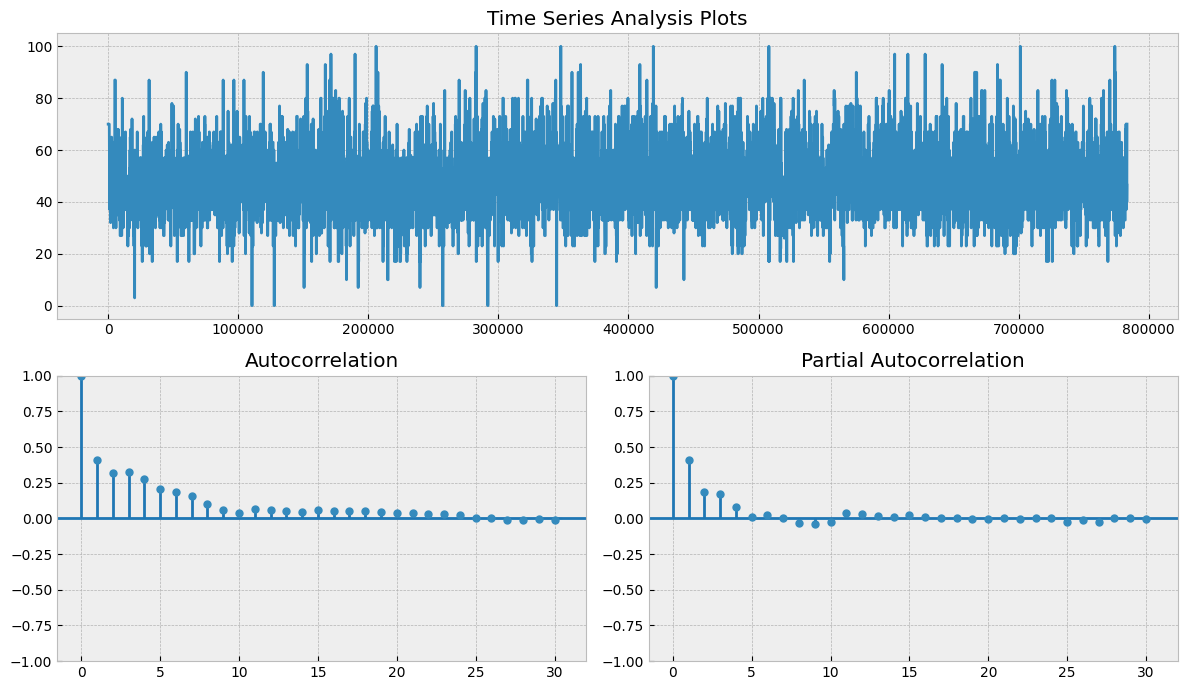

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(x_0_y_0_EB_all.overload, lags=30)

In [29]:
# x_0_y_0_EB_all['overload_diff'] = x_0_y_0_EB_all.overload - x_0_y_0_EB_all.overload.shift(1)
# tsplot(x_0_y_0_EB_all.overload_diff[24*7+1:], lags=30)

Критерий Дики-Фуллера: p=0.000000


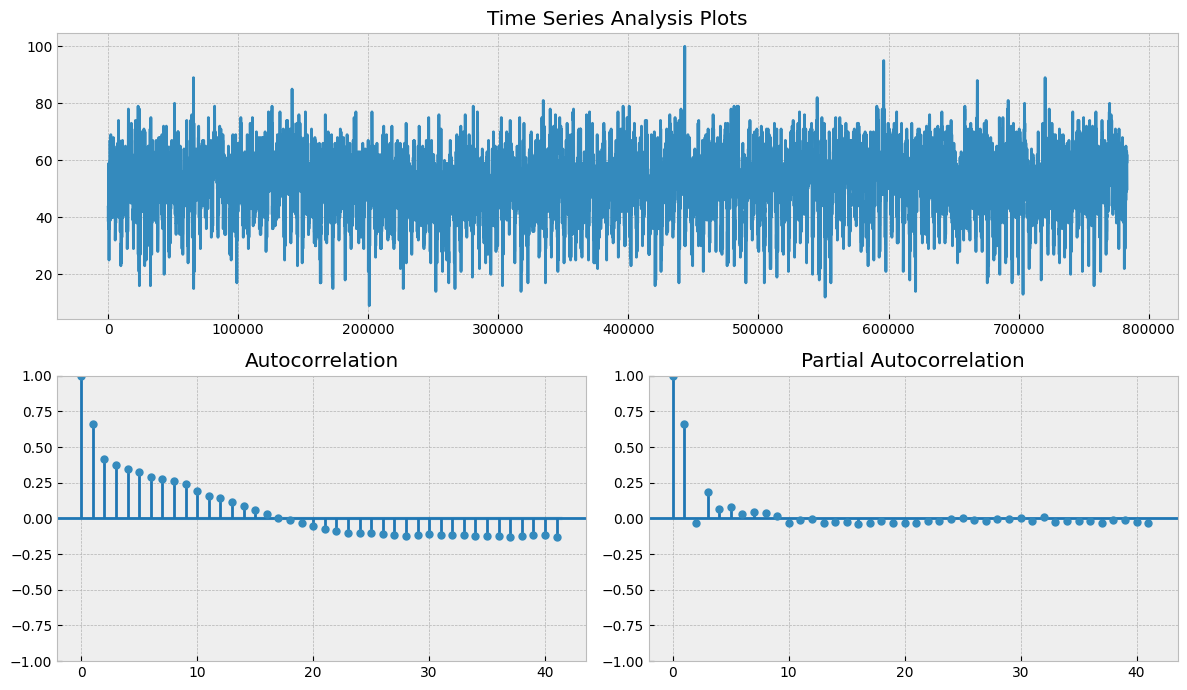

In [30]:
tsplot(x_1_y_1_SB_all.overload)

**хотя из выборки была отброшена значительная часть данных, модель долго учится, поэтому решено делать предсказания с помощью бустинга. он также решает проблему одной модели вместо нескольких**

In [33]:
# d=1
# D=1

# data = x_0_y_0_EB_all
# data = data[data['time'] > datetime.datetime(2023, 9, 15)]
# len(x_0_y_0_EB_all), len(data)

In [34]:
# %%time
# best_model = sm.tsa.statespace.SARIMAX(data.overload, order=(4, d, 3), 
#                                         seasonal_order=(4, D, 1, 24)).fit(disp=-1)

In [35]:
# data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
# forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
# forecast = data.arima_model.append(forecast).values[-500:]
# actual = data.overload.values[-400:]
# plt.figure(figsize=(15, 7))
# plt.plot(forecast, color='r', label="model")
# plt.title("SARIMA model\n Mean absolute error {} overload".format(round(mean_absolute_error(data.dropna().overload, data.dropna().arima_model))))
# plt.plot(actual, label="actual")
# plt.legend()
# plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
# plt.grid(True)

In [ ]:
## пройтись sarima по всем уникальным x, y, dir или группироовать их?